# __Анализ конверсии.__  
## В приведенном ниже коде выполенен анализ конверсий, по пазлам, показа в старт, старта в комплит, старта в выход в следующих срезах:  
1. Общие конверсии (по всем difficulty).  
2. Общие конверсии (по всем difficulty) по следующим версиям приложения: 1.3.33, 1.4, 1.4.1, 1.4.3.  
3. Конверсии, только по difficulty = 36, для первых стартов пользователя, по следующим версиям приложения: 1.3.33, 1.4, 1.4.1, 1.4.3.  
4. Конверсии, только по difficulty = 36, для вторых стартов пользователя, по следующим версиям приложения: 1.3.33, 1.4, 1.4.1, 1.4.3.
5. Общие конверсии (по всем difficulty), для пазлов разной сложности.

In [1]:
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

## Загружаем данные из файла
## Данные за 01.03.22 - 15.05.22

In [2]:
data=pd.read_csv('16.05.22 full_version_evname_json_date.csv')
data.head()

,app_version_name,event_name,event_json,event_datetime
0,1.4.1,app_start,"{""balance"":""450"",""days_in_game"":""0"",""PuzzleCom...",2022-04-21 12:58:04
1,1.4.1,balance_change,"{""Currency"":""coins"",""Balance"":""450"",""balance"":...",2022-04-21 12:58:03
2,1.4.1,game_puzzle_click,"{""category_id"":""13"",""puzzle_id"":""38"",""Order_nu...",2022-04-21 12:58:45
3,1.4.1,game_puzzle_pause,"{""puzzle_id"":""38"",""Order_number"":""38"",""categor...",2022-04-21 12:59:03
4,1.4.1,game_puzzle_receive,"{""place"":""daily"",""category_id"":""13"",""Order_num...",2022-04-21 12:58:47


## Оставляем в датафрейме только event_name связанные с пазлами:  
'show_image'  
'game_puzzle_start'  
'game_puzzle_complete'  
'game_puzzle_quit'  
## В json блоке оставляем нужное и собирем один датафрейм

In [3]:
data=data[data['event_name'].isin(\
    ['show_image', 'game_puzzle_start', 'game_puzzle_complete', 'game_puzzle_quit']\
        )].reset_index(drop=True)

# развернем json
data_json = pd.json_normalize(list(map(json.loads, data.event_json)))

# сформируем фрейм с которым будем работать
data_work = data[['event_name', 'event_datetime', 'app_version_name']]

# добавим столбец с единым идентификатором пазла
data_work['cat_puzzle_id'] = data_json.category_id.astype(str) + '_' + data_json.puzzle_id.astype(str)

# сконкатим фреймы data и json
data_work = pd.concat([data_work, data_json[[\
    'category_id','place','days_in_game','PuzzleComplete','PuzzleStart','Rotate','Difficulty','completed','started']\
        ]], axis=1)

# Преобразуем типы данных
data_work['PuzzleComplete'] =pd.to_numeric(data_work.PuzzleComplete)
data_work['PuzzleStart'] =pd.to_numeric(data_work.PuzzleStart)

## Датафрейм, со всем необходимым

In [4]:
data_work.head(3)

,event_name,event_datetime,app_version_name,cat_puzzle_id,category_id,place,days_in_game,PuzzleComplete,PuzzleStart,Rotate,Difficulty,completed,started
0,show_image,2022-04-21 09:34:57,1.4.1,1_100,1,category,0,0.0,1.0,NaN,NaN,0,0
1,show_image,2022-04-21 09:34:57,1.4.1,1_87,1,category,0,0.0,1.0,NaN,NaN,0,0
2,show_image,2022-04-21 09:34:58,1.4.1,1_12,1,category,0,0.0,1.0,NaN,NaN,0,0


## Оставим в нашем датафрейме только события в которых place == daily, catalog  
### будем считать что так мы выделим релевантные данные для оценки конверсии/привлекательности пазлов

In [5]:
data_work = data_work[data_work['place'].isin(['daily', 'catalog'])]

## Опишем функцию которая посчитает для переданого датафрейма:
Показы  
Старты  
Комплиты  
Конверсию показов в старты  
Конверсию стартов в комплиты  
Конверсию стартов в quitы

In [6]:
def conversion_count_simply(data, mask, difficulty=['36','49','144','256','441'], version=['1.3.33', '1.4', '1.4.1', '1.4.3']):

    # будем работать только с заданными версиями приложения
    data = data[data['app_version_name'].isin(version)]
    
    # считаем столбец показов
    show_image = data.query('event_name=="show_image" and completed !="1"').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    show_image.rename(columns={'event_name':'shows_'+mask}, inplace=True)
    show_image.reset_index(inplace=True)

    # будем работать только с заданными сложностями
    data = data[data['Difficulty'].isin(difficulty)]

    # старты пазлов со сложностью difficulty
    game_puzzle_start = data.query('event_name=="game_puzzle_start"').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_start.rename(columns={'event_name':'starts_'+mask}, inplace=True)
    game_puzzle_start.reset_index(inplace=True)

    # комплиты пазлов со сложнотью difficulty
    game_puzzle_complete = data.query('event_name=="game_puzzle_complete"').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_complete.rename(columns={'event_name':'complets_'+mask}, inplace=True)
    game_puzzle_complete.reset_index(inplace=True)

    # quitы пазлов со сложностью difficulty
    game_puzzle_quit = data.query('event_name=="game_puzzle_quit"').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_quit.rename(columns={'event_name':'quits_'+mask}, inplace=True)
    game_puzzle_quit.reset_index(inplace=True)

    # удалим странный пазл
    show_image = show_image.query('cat_puzzle_id != "23_38"').reset_index(drop=True)

    # объединим в один полученные фреймы
    data_count_all = show_image.merge(game_puzzle_start, how='left').merge(game_puzzle_complete, how='left').merge(game_puzzle_quit, how='left')

    # заполним пропуски нулями
    data_count_all = data_count_all.fillna(0)

    # посчитаем конверсии
    data_count_all['conv_to_start_'+mask] = round (data_count_all['starts_'+mask] / data_count_all['shows_'+mask] * 100, 2)
    data_count_all['conv_to_quit_'+mask] = round (data_count_all['quits_'+mask] / data_count_all['starts_'+mask] * 100, 2)
    data_count_all['conv_to_complete_'+mask] = round (data_count_all['complets_'+mask] / data_count_all['starts_'+mask] * 100, 2)

    # уберем нули и бесконечности
    data_count_all = data_count_all.fillna(0)
    data_count_all = data_count_all.replace(np.inf, 0)

    # Посчитаем доверительные интервалы, по методу Вальда, для конверсии старт в комплит
    temp_frame = pd.DataFrame()
    temp_frame['s'] = 1.96 * np.sqrt( (data_count_all['conv_to_complete_'+mask] * (100 - data_count_all['conv_to_complete_'+mask])) / (data_count_all['starts_'+mask])) 
    data_count_all['low_'+mask] = round( data_count_all['conv_to_complete_'+mask] - temp_frame['s'], 2)
    data_count_all['high_'+mask] = round(data_count_all['conv_to_complete_'+mask] + temp_frame['s'], 2)
    
    # Посчитаем доверительные интервалы, по методу/преобразованию Фишера, для конверсии старт в комплит
    #temp_frame = pd.DataFrame()
    #temp_frame['fi'] = 2 * np.arcsin( np.sqrt(data_count_all['conv_to_complete_'+mask]/100  ) )
    #data_count_all['low_'+mask] = round(100* np.sin ( ( temp_frame['fi'] - 1.96*(1/np.sqrt(data_count_all['starts_'+mask])) )/2 )**2, 2)
    #data_count_all['high_'+mask] = round(100*  np.sin ( ( temp_frame['fi'] + 1.96*(1/np.sqrt(data_count_all['starts_'+mask])) )/2 )**2, 2)

    return data_count_all



## Опишем функцию которая посчитает для переданого датафрейма ПЕРВЫЕ конверсии:


In [7]:
def conversion_count_first(data, mask, difficulty=['36','49','144','256','441'], version=['1.3.33', '1.4', '1.4.1', '1.4.3']):

    # будем работать только с заданными версиями приложения
    data = data[data['app_version_name'].isin(version)]
    
    # считаем столбец показов
    show_image = data.query('event_name=="show_image" and completed !="1" and PuzzleStart == 0').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    show_image.rename(columns={'event_name':'shows_'+mask}, inplace=True)
    show_image.reset_index(inplace=True)

    # будем работать только с заданными сложностями
    data = data[data['Difficulty'].isin(difficulty)]

    # старты пазлов со сложностью difficulty
    game_puzzle_start = data.query('event_name=="game_puzzle_start" and PuzzleStart == 0').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_start.rename(columns={'event_name':'starts_'+mask}, inplace=True)
    game_puzzle_start.reset_index(inplace=True)

    # комплиты пазлов со сложнотью difficulty
    game_puzzle_complete = data.query('event_name=="game_puzzle_complete" and PuzzleComplete == 1').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_complete.rename(columns={'event_name':'complets_'+mask}, inplace=True)
    game_puzzle_complete.reset_index(inplace=True)

    # quitы пазлов со сложностью difficulty
    game_puzzle_quit = data.query('event_name=="game_puzzle_quit" and PuzzleStart == 1').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_quit.rename(columns={'event_name':'quits_'+mask}, inplace=True)
    game_puzzle_quit.reset_index(inplace=True)

    # удалим странный пазл
    show_image = show_image.query('cat_puzzle_id != "23_38"').reset_index(drop=True)

    # объединим в один полученные фреймы
    data_count_all = show_image.merge(game_puzzle_start, how='left').merge(game_puzzle_complete, how='left').merge(game_puzzle_quit, how='left')

    # заполним пропуски нулями
    data_count_all = data_count_all.fillna(0)

    # посчитаем конверсии
    data_count_all['conv_to_start_'+mask] = round (data_count_all['starts_'+mask] / data_count_all['shows_'+mask] * 100, 2)
    data_count_all['conv_to_quit_'+mask] = round (data_count_all['quits_'+mask] / data_count_all['starts_'+mask] * 100, 2)
    data_count_all['conv_to_complete_'+mask] = round (data_count_all['complets_'+mask] / data_count_all['starts_'+mask] * 100, 2)

    # уберем нули и бесконечности
    data_count_all = data_count_all.fillna(0)
    data_count_all = data_count_all.replace(np.inf, 0)

    # Посчитаем доверительные интервалы, по методу Вальда, для конверсии старт в комплит
    temp_frame = pd.DataFrame()
    temp_frame['s'] = 1.96 * np.sqrt( (data_count_all['conv_to_complete_'+mask] * (100 - data_count_all['conv_to_complete_'+mask])) / (data_count_all['starts_'+mask])) 
    data_count_all['low_'+mask] = round( data_count_all['conv_to_complete_'+mask] - temp_frame['s'], 2)
    data_count_all['high_'+mask] = round(data_count_all['conv_to_complete_'+mask] + temp_frame['s'], 2)
    
    # Посчитаем доверительные интервалы, по методу/преобразованию Фишера, для конверсии старт в комплит
    #temp_frame = pd.DataFrame()
    #temp_frame['fi'] = 2 * np.arcsin( np.sqrt(data_count_all['conv_to_complete_'+mask]/100  ) )
    #data_count_all['low_'+mask] = round(100* np.sin ( ( temp_frame['fi'] - 1.96*(1/np.sqrt(data_count_all['starts_'+mask])) )/2 )**2, 2)
    #data_count_all['high_'+mask] = round(100*  np.sin ( ( temp_frame['fi'] + 1.96*(1/np.sqrt(data_count_all['starts_'+mask])) )/2 )**2, 2)

    return data_count_all



## Опишем функцию которая посчитает для переданого датафрейма ПЕРВЫЕ ПЛЮС конверсии:

In [8]:
def conversion_count_first_plus(data, mask, difficulty=['36','49','144','256','441'], version=['1.3.33', '1.4', '1.4.1', '1.4.3']):

    # будем работать только с заданными версиями приложения
    data = data[data['app_version_name'].isin(version)]
    
    # считаем столбец показов
    show_image = data.query('event_name=="show_image" and completed !="1" and PuzzleStart >0').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    show_image.rename(columns={'event_name':'shows_'+mask}, inplace=True)
    show_image.reset_index(inplace=True)

    # будем работать только с заданными сложностями
    data = data[data['Difficulty'].isin(difficulty)]

    # старты пазлов со сложностью difficulty
    game_puzzle_start = data.query('event_name=="game_puzzle_start" and PuzzleStart > 0').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_start.rename(columns={'event_name':'starts_'+mask}, inplace=True)
    game_puzzle_start.reset_index(inplace=True)

    # комплиты пазлов со сложнотью difficulty
    game_puzzle_complete = data.query('event_name=="game_puzzle_complete" and PuzzleComplete > 1').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_complete.rename(columns={'event_name':'complets_'+mask}, inplace=True)
    game_puzzle_complete.reset_index(inplace=True)

    # quitы пазлов со сложностью difficulty
    game_puzzle_quit = data.query('event_name=="game_puzzle_quit" and PuzzleStart > 1').groupby(by=['cat_puzzle_id', 'category_id']).count().iloc[:,0:1]
    game_puzzle_quit.rename(columns={'event_name':'quits_'+mask}, inplace=True)
    game_puzzle_quit.reset_index(inplace=True)

    # удалим странный пазл
    show_image = show_image.query('cat_puzzle_id != "23_38"').reset_index(drop=True)

    # объединим в один полученные фреймы
    data_count_all = show_image.merge(game_puzzle_start, how='left').merge(game_puzzle_complete, how='left').merge(game_puzzle_quit, how='left')

    # заполним пропуски нулями
    data_count_all = data_count_all.fillna(0)

    # посчитаем конверсии
    data_count_all['conv_to_start_'+mask] = round (data_count_all['starts_'+mask] / data_count_all['shows_'+mask] * 100, 2)
    data_count_all['conv_to_quit_'+mask] = round (data_count_all['quits_'+mask] / data_count_all['starts_'+mask] * 100, 2)
    data_count_all['conv_to_complete_'+mask] = round (data_count_all['complets_'+mask] / data_count_all['starts_'+mask] * 100, 2)

    # уберем нули и бесконечности
    data_count_all = data_count_all.fillna(0)
    data_count_all = data_count_all.replace(np.inf, 0)

    # Посчитаем доверительные интервалы, по методу Вальда, для конверсии старт в комплит
    temp_frame = pd.DataFrame()
    temp_frame['s'] = 1.96 * np.sqrt( (data_count_all['conv_to_complete_'+mask] * (100 - data_count_all['conv_to_complete_'+mask])) / (data_count_all['starts_'+mask])) 
    data_count_all['low_'+mask] = round( data_count_all['conv_to_complete_'+mask] - temp_frame['s'], 2)
    data_count_all['high_'+mask] = round(data_count_all['conv_to_complete_'+mask] + temp_frame['s'], 2)
    
    # Посчитаем доверительные интервалы, по методу/преобразованию Фишера, для конверсии старт в комплит
    #temp_frame = pd.DataFrame()
    #temp_frame['fi'] = 2 * np.arcsin( np.sqrt(data_count_all['conv_to_complete_'+mask]/100  ) )
    #data_count_all['low_'+mask] = round(100* np.sin ( ( temp_frame['fi'] - 1.96*(1/np.sqrt(data_count_all['starts_'+mask])) )/2 )**2, 2)
    #data_count_all['high_'+mask] = round(100*  np.sin ( ( temp_frame['fi'] + 1.96*(1/np.sqrt(data_count_all['starts_'+mask])) )/2 )**2, 2)

    return data_count_all



# Расчитаем конверсии

## Итоговая таблица конверсий для всех стартов, по версиям, для всех Difficulty, по пазлам

In [9]:
# полный список версий из фрейма
versions_list = list(data_work['app_version_name'].value_counts().index)
# применяем для расчета занчений_full

In [11]:
diff = ['36','49','144','256','441']
conversion_table_simply = pd.concat([conversion_count_simply(data_work, 'full', version=versions_list, difficulty=diff),
        conversion_count_simply(data_work, '1.3.33', version=['1.3.33'], difficulty=diff).iloc[:,2:],
            conversion_count_simply(data_work, '1.4', version=['1.4'], difficulty=diff).iloc[:,2:],
                conversion_count_simply(data_work, '1.4.1', version=['1.4.1'], difficulty=diff).iloc[:,2:],
                    conversion_count_simply(data_work, '1.4.3', version=['1.4.3'], difficulty=diff).iloc[:,2:]
                        ], axis=1)

conversion_table_simply.sort_values('shows_full',ascending=False).head(25)

c:\Users\sorok\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,cat_puzzle_id,category_id,shows_full,starts_full,complets_full,quits_full,conv_to_start_full,conv_to_quit_full,conv_to_complete_full,low_full,...,high_1.4.1,shows_1.4.3,starts_1.4.3,complets_1.4.3,quits_1.4.3,conv_to_start_1.4.3,conv_to_quit_1.4.3,conv_to_complete_1.4.3,low_1.4.3,high_1.4.3
371,1_33,1,84859,4665,3149,508.0,5.50,10.89,67.50,66.16,...,65.19,11353,551.0,346.0,67.0,4.85,12.16,62.79,58.75,66.83
873,31_8,31,78508,4254,2790,495.0,5.42,11.64,65.59,64.16,...,63.43,172,2.0,0.0,1.0,1.16,50.00,0.00,0.00,0.00
964,34_1,34,75769,3927,2472,549.0,5.18,13.98,62.95,61.44,...,61.51,223,9.0,5.0,2.0,4.04,22.22,55.56,23.10,88.02
496,21_3,21,69641,4475,2757,618.0,6.43,13.81,61.61,60.19,...,58.62,205,4.0,3.0,0.0,1.95,0.00,75.00,32.56,117.44
815,31_27,31,13024,504,337,40.0,3.87,7.94,66.87,62.76,...,84.79,12698,449.0,297.0,37.0,3.54,8.24,66.15,61.77,70.53
255,16_26,16,11109,556,359,76.0,5.00,13.67,64.57,60.59,...,97.94,9842,460.0,288.0,70.0,4.67,15.22,62.61,58.19,67.03
376,1_38,1,11007,628,406,68.0,5.71,10.83,64.65,60.91,...,99.05,10639,570.0,359.0,66.0,5.36,11.58,62.98,59.02,66.94
1259,7_40,7,10704,517,321,56.0,4.83,10.83,62.09,57.91,...,104.94,10145,487.0,295.0,56.0,4.80,11.50,60.57,56.23,64.91
499,21_32,21,10466,936,536,107.0,8.94,11.43,57.26,54.09,...,62.04,10022,911.0,521.0,105.0,9.09,11.53,57.19,53.98,60.40
405,1_64,1,9181,1766,976,261.0,19.24,14.78,55.27,52.95,...,103.71,8827,1704.0,924.0,260.0,19.30,15.26,54.23,51.86,56.60


## Оценим распределение conv_to_complete_full

<AxesSubplot:>

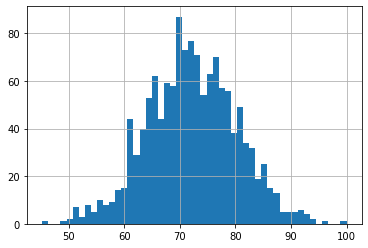

In [76]:
conversion_table_simply['conv_to_complete_full'].hist(bins=50)

c:\Users\sorok\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


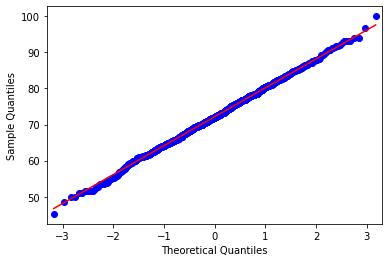

In [14]:
from statsmodels.graphics.gofplots import qqplot
qqplot(conversion_table_simply['conv_to_complete_full'], line='s')
plt.show()

In [13]:
# Полная конверсия распределена нормально.
import scipy
stat, p = scipy.stats.shapiro(list(conversion_table_simply.conv_to_complete_full)) # тест Шапиро-Уилкa
print('Statistics=%.3f, p-value=%.5f' % (stat, p))

Statistics=0.999, p-value=0.86997


Полная конверсия ао всем пазлам, по всем категориям и версиям распределена нормально

## Итоговая таблица конверсий для ПЕРВЫХ стартов, по версиям, для всех Difficulty = 36, по пазлам

In [15]:
diff = ['36']
conversion_table_first = pd.concat([conversion_count_first(data_work, 'full', difficulty=diff, version=versions_list),
        conversion_count_first(data_work, '1.3.33', version=['1.3.33'], difficulty=diff).iloc[:,2:],
            conversion_count_first(data_work, '1.4', version=['1.4'], difficulty=diff).iloc[:,2:],
                conversion_count_first(data_work, '1.4.1', version=['1.4.1'], difficulty=diff).iloc[:,2:],
                    conversion_count_first(data_work, '1.4.3', version=['1.4.3'], difficulty=diff).iloc[:,2:]
                        ], axis=1)
conversion_table_first.sort_values('shows_full',ascending=False).head(25)

c:\Users\sorok\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,cat_puzzle_id,category_id,shows_full,starts_full,complets_full,quits_full,conv_to_start_full,conv_to_quit_full,conv_to_complete_full,low_full,...,high_1.4.1,shows_1.4.3,starts_1.4.3,complets_1.4.3,quits_1.4.3,conv_to_start_1.4.3,conv_to_quit_1.4.3,conv_to_complete_1.4.3,low_1.4.3,high_1.4.3
371,1_33,1,22034,596.0,360.0,84.0,2.70,14.09,60.40,56.47,...,59.08,2856.0,112.0,64.0,13.0,3.92,11.61,57.14,47.97,66.31
873,31_8,31,20303,886.0,580.0,109.0,4.36,12.30,65.46,62.33,...,62.80,9.0,0.0,0.0,0.0,0.00,0.00,0.00,NaN,NaN
964,34_1,34,19807,811.0,493.0,125.0,4.09,15.41,60.79,57.43,...,55.50,4.0,0.0,0.0,0.0,0.00,0.00,0.00,NaN,NaN
496,21_3,21,18736,1263.0,705.0,183.0,6.74,14.49,55.82,53.08,...,54.19,8.0,0.0,0.0,0.0,0.00,0.00,0.00,NaN,NaN
815,31_27,31,3070,41.0,26.0,2.0,1.34,4.88,63.41,48.67,...,117.44,4.0,0.0,0.0,0.0,0.00,0.00,0.00,NaN,NaN
405,1_64,1,2967,964.0,578.0,141.0,32.49,14.63,59.96,56.87,...,0.00,7.0,0.0,0.0,0.0,0.00,0.00,0.00,NaN,NaN
499,21_32,21,2838,195.0,95.0,36.0,6.87,18.46,48.72,41.70,...,100.00,9.0,0.0,0.0,0.0,0.00,0.00,0.00,NaN,NaN
376,1_38,1,2823,115.0,71.0,16.0,4.07,13.91,61.74,52.86,...,100.00,2755.0,112.0,67.0,16.0,4.07,14.29,59.82,50.74,68.90
1259,7_40,7,2665,55.0,31.0,6.0,2.06,10.91,56.36,43.25,...,NaN,8.0,0.0,0.0,0.0,0.00,0.00,0.00,NaN,NaN
255,16_26,16,2629,102.0,60.0,25.0,3.88,24.51,58.82,49.27,...,100.00,2438.0,91.0,52.0,24.0,3.73,26.37,57.14,46.97,67.31


## Итоговая таблица конверсий для первых ПЛЮС стартов, по версиям, для всех Difficulty = 36, по пазлам

In [17]:
diff = ['36']
conversion_table_first_plus = pd.concat([conversion_count_first_plus(data_work, 'full', difficulty=diff, version=versions_list),
        conversion_count_first_plus(data_work, '1.3.33', version=['1.3.33'], difficulty=diff).iloc[:,2:],
            conversion_count_first_plus(data_work, '1.4', version=['1.4'], difficulty=diff).iloc[:,2:],
                conversion_count_first_plus(data_work, '1.4.1', version=['1.4.1'], difficulty=diff).iloc[:,2:],
                    conversion_count_first_plus(data_work, '1.4.3', version=['1.4.3'], difficulty=diff).iloc[:,2:]
                        ], axis=1)
conversion_table_first_plus.sort_values('shows_full',ascending=False).head(25)

c:\Users\sorok\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,cat_puzzle_id,category_id,shows_full,starts_full,complets_full,quits_full,conv_to_start_full,conv_to_quit_full,conv_to_complete_full,low_full,...,high_1.4.1,shows_1.4.3,starts_1.4.3,complets_1.4.3,quits_1.4.3,conv_to_start_1.4.3,conv_to_quit_1.4.3,conv_to_complete_1.4.3,low_1.4.3,high_1.4.3
371,1_33,1,62824,3006,2280,218.0,4.78,7.25,75.85,74.32,...,74.96,8497,313.0,227.0,32.0,3.68,10.22,72.52,67.57,77.47
873,31_8,31,58205,2237,1697,173.0,3.84,7.73,75.86,74.09,...,76.00,164,0.0,0.0,0.0,0.00,0.00,0.00,NaN,NaN
964,34_1,34,55962,1990,1499,167.0,3.56,8.39,75.33,73.44,...,75.03,199,6.0,4.0,1.0,3.02,16.67,66.67,28.95,104.39
496,21_3,21,50905,2214,1595,220.0,4.35,9.94,72.04,70.17,...,69.99,198,2.0,2.0,0.0,1.01,0.00,100.00,100.00,100.00
815,31_27,31,9954,286,214,17.0,2.87,5.94,74.83,69.80,...,105.01,9687,254.0,187.0,17.0,2.62,6.69,73.62,68.20,79.04
255,16_26,16,8480,292,215,23.0,3.44,7.88,73.63,68.58,...,99.82,7404,246.0,178.0,21.0,3.32,8.54,72.36,66.77,77.95
376,1_38,1,8184,337,251,17.0,4.12,5.04,74.48,69.83,...,98.40,7884,293.0,215.0,17.0,3.72,5.80,73.38,68.32,78.44
1259,7_40,7,8038,320,226,23.0,3.98,7.19,70.62,65.63,...,100.00,7553,303.0,210.0,23.0,4.01,7.59,69.31,64.12,74.50
499,21_32,21,7628,509,348,40.0,6.67,7.86,68.37,64.33,...,86.67,7251,495.0,337.0,40.0,6.83,8.08,68.08,63.97,72.19
506,21_39,21,6718,239,160,24.0,3.56,10.04,66.95,60.99,...,93.80,6280,216.0,145.0,24.0,3.44,11.11,67.13,60.87,73.39


## Выведем средние и доверительные интервалы для средних по всем конверсиям и версиям в одну таблицу.  
### (starts hits, % - процент наблюдений стартов приходящихся на версию приложения)

In [18]:
conv_list = ['conv_to_start_full','conv_to_complete_full','conv_to_quit_full',\
    'conv_to_start_1.3.33','conv_to_complete_1.3.33','conv_to_quit_1.3.33',\
        'conv_to_start_1.4','conv_to_complete_1.4','conv_to_quit_1.4',\
           'conv_to_start_1.4.1','conv_to_complete_1.4.1','conv_to_quit_1.4.1',\
               'conv_to_start_1.4.3','conv_to_complete_1.4.3','conv_to_quit_1.4.3']

In [19]:
conversion_only = conversion_table_simply[conv_list]

conv_matrix_simply = pd.DataFrame(columns=['full', 'v1.3.33', 'v1.4', 'v1.4.1', 'v1.4.3'], index = ['conv_to_start', 'conv_to_complete', 'conv_to_quit'])
counter = 0
for i in range(5):
    t=[]
    
    for j in range(3):
        x= []
        y=[]
        y = np.round(list(st.t.interval(0.95, len(conversion_only.iloc[:,counter])-1, loc=np.mean(conversion_only.iloc[:,counter]), scale=st.sem(conversion_only.iloc[:,counter]))),2)
        x.append(round(conversion_only.iloc[:,counter].mean(),2))
        x.append(list(y))
        counter+=1
        t.append(x)
    conv_matrix_simply.iloc[:,i] = t
conv_matrix_simply

,full,v1.3.33,v1.4,v1.4.1,v1.4.3
conv_to_start,"[6.24, [6.1, 6.38]]","[7.36, [nan, nan]]","[5.9, [5.72, 6.08]]","[7.23, [7.03, 7.43]]","[4.77, [4.62, 4.92]]"
conv_to_complete,"[72.16, [71.73, 72.59]]","[27.06, [nan, nan]]","[75.69, [74.97, 76.41]]","[67.6, [66.75, 68.46]]","[74.22, [72.8, 75.64]]"
conv_to_quit,"[9.31, [9.04, 9.59]]","[0.9, [nan, nan]]","[10.37, [9.74, 11.0]]","[10.51, [9.91, 11.11]]","[6.56, [5.83, 7.3]]"


In [20]:
conversion_only = conversion_table_first[conv_list]

conv_matrix_first = pd.DataFrame(columns=['full', 'v1.3.33', 'v1.4', 'v1.4.1', 'v1.4.3'], index = ['conv_to_start_first', 'conv_to_complete_first', 'conv_to_quit_first'])
counter = 0
for i in range(5):
    t=[]
    for j in range(3):
        x= []
        y=[]
        y = np.round(list(st.t.interval(0.95, len(conversion_only.iloc[:,counter])-1, loc=np.mean(conversion_only.iloc[:,counter]), scale=st.sem(conversion_only.iloc[:,counter]))),2)
        x.append(round(conversion_only.iloc[:,counter].mean(),2))
        x.append(list(y))
        counter+=1
        t.append(x)
    conv_matrix_first.iloc[:,i] = t
conv_matrix_first

,full,v1.3.33,v1.4,v1.4.1,v1.4.3
conv_to_start_first,"[4.64, [4.51, 4.77]]","[2.17, [nan, nan]]","[5.46, [5.22, 5.7]]","[5.63, [5.37, 5.89]]","[0.91, [nan, nan]]"
conv_to_complete_first,"[63.58, [62.08, 65.09]]","[3.62, [nan, nan]]","[58.48, [56.1, 60.86]]","[44.54, [42.31, 46.76]]","[7.09, [nan, nan]]"
conv_to_quit_first,"[12.66, [11.75, 13.57]]","[0.44, [nan, nan]]","[10.45, [9.23, 11.68]]","[11.54, [10.01, 13.06]]","[1.56, [nan, nan]]"


In [21]:
conversion_only = conversion_table_first_plus[conv_list]

conv_matrix_first_plus = pd.DataFrame(columns=['full', 'v1.3.33', 'v1.4', 'v1.4.1', 'v1.4.3'], index = ['conv_to_start_first_plus', 'conv_to_complete_first_plus', 'conv_to_quit_first_plus'])
counter = 0
for i in range(5):
    t=[]
    for j in range(3):
        x= []
        y=[]
        y = np.round(list(st.t.interval(0.95, len(conversion_only.iloc[:,counter])-1, loc=np.mean(conversion_only.iloc[:,counter]), scale=st.sem(conversion_only.iloc[:,counter]))),2)
        x.append(round(conversion_only.iloc[:,counter].mean(),2))
        x.append(list(y))
        counter+=1
        t.append(x)
    conv_matrix_first_plus.iloc[:,i] = t
conv_matrix_first_plus

,full,v1.3.33,v1.4,v1.4.1,v1.4.3
conv_to_start_first_plus,"[3.98, [3.86, 4.09]]","[3.48, [nan, nan]]","[3.52, [3.38, 3.66]]","[5.06, [4.87, 5.25]]","[3.37, [3.25, 3.5]]"
conv_to_complete_first_plus,"[80.72, [80.23, 81.22]]","[12.92, [nan, nan]]","[83.79, [82.74, 84.85]]","[76.65, [75.6, 77.7]]","[73.2, [71.36, 75.04]]"
conv_to_quit_first_plus,"[6.18, [5.89, 6.48]]","[0.0, [nan, nan]]","[7.19, [6.6, 7.77]]","[7.57, [6.85, 8.3]]","[4.18, [3.46, 4.9]]"


In [22]:
result_matrix = pd.concat([conv_matrix_simply, conv_matrix_first, conv_matrix_first_plus])
start_hits_list = ['starts_full', 'starts_1.3.33' ,'starts_1.4' ,'starts_1.4.1','starts_1.4.3']

start_hits=[]
for i in start_hits_list:
    start_hits.append(round(conversion_table_simply[i].sum()*100/conversion_table_simply[start_hits_list[0]].sum(),1))
result_matrix.loc['starts hits, %'] = start_hits
result_matrix

,full,v1.3.33,v1.4,v1.4.1,v1.4.3
conv_to_start,"[6.24, [6.1, 6.38]]","[7.36, [nan, nan]]","[5.9, [5.72, 6.08]]","[7.23, [7.03, 7.43]]","[4.77, [4.62, 4.92]]"
conv_to_complete,"[72.16, [71.73, 72.59]]","[27.06, [nan, nan]]","[75.69, [74.97, 76.41]]","[67.6, [66.75, 68.46]]","[74.22, [72.8, 75.64]]"
conv_to_quit,"[9.31, [9.04, 9.59]]","[0.9, [nan, nan]]","[10.37, [9.74, 11.0]]","[10.51, [9.91, 11.11]]","[6.56, [5.83, 7.3]]"
conv_to_start_first,"[4.64, [4.51, 4.77]]","[2.17, [nan, nan]]","[5.46, [5.22, 5.7]]","[5.63, [5.37, 5.89]]","[0.91, [nan, nan]]"
conv_to_complete_first,"[63.58, [62.08, 65.09]]","[3.62, [nan, nan]]","[58.48, [56.1, 60.86]]","[44.54, [42.31, 46.76]]","[7.09, [nan, nan]]"
conv_to_quit_first,"[12.66, [11.75, 13.57]]","[0.44, [nan, nan]]","[10.45, [9.23, 11.68]]","[11.54, [10.01, 13.06]]","[1.56, [nan, nan]]"
conv_to_start_first_plus,"[3.98, [3.86, 4.09]]","[3.48, [nan, nan]]","[3.52, [3.38, 3.66]]","[5.06, [4.87, 5.25]]","[3.37, [3.25, 3.5]]"
conv_to_complete_first_plus,"[80.72, [80.23, 81.22]]","[12.92, [nan, nan]]","[83.79, [82.74, 84.85]]","[76.65, [75.6, 77.7]]","[73.2, [71.36, 75.04]]"
conv_to_quit_first_plus,"[6.18, [5.89, 6.48]]","[0.0, [nan, nan]]","[7.19, [6.6, 7.77]]","[7.57, [6.85, 8.3]]","[4.18, [3.46, 4.9]]"
"starts hits, %",100.0,0.7,31.7,22.0,12.8


### ОБращаем внимание на NaN в столбце с версией приложения 1.3.33, причина странных значений средних конверсий и NaN в доверительных интервалах - очень маленькое количество наблюдений, версия 1.3.333 практически не жила, кроме того в версии жизни приложения 1.4.3 наблюдаются аномалии (уменьшение количества новых пользователней), отсюда нетипичные показатели по конверсии conv_to_complete_first

## Таблица конверсий разных сложностей (без разбивки по версиям)

In [23]:
dif_ty=['36','49','144','256','441']

conversion_table_difficulty = pd.concat([conversion_count_simply(data_work, 'full', difficulty=dif_ty, version=versions_list),\
    conversion_count_simply(data_work, '36', ['36'], version=versions_list).iloc[:,2:120],\
        conversion_count_simply(data_work, '49', ['49'], version=versions_list).iloc[:,2:120],\
            conversion_count_simply(data_work, '144', ['144'], version=versions_list).iloc[:,2:120],\
                conversion_count_simply(data_work, '256', ['256'], version=versions_list).iloc[:,2:120],\
                    conversion_count_simply(data_work, '441', ['441'], version=versions_list).iloc[:,2:120]], axis=1)

conversion_table_difficulty.sort_values('shows_full', ascending=False).head()

c:\Users\sorok\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,cat_puzzle_id,category_id,shows_full,starts_full,complets_full,quits_full,conv_to_start_full,conv_to_quit_full,conv_to_complete_full,low_full,...,high_256,shows_441,starts_441,complets_441,quits_441,conv_to_start_441,conv_to_quit_441,conv_to_complete_441,low_441,high_441
371,1_33,1,84859,4665,3149,508.0,5.50,10.89,67.50,66.16,...,13.65,84859,87.0,0.0,39.0,0.10,44.83,0.00,0.00,0.00
873,31_8,31,78508,4254,2790,495.0,5.42,11.64,65.59,64.16,...,12.09,78508,116.0,1.0,39.0,0.15,33.62,0.86,-0.82,2.54
964,34_1,34,75769,3927,2472,549.0,5.18,13.98,62.95,61.44,...,8.12,75769,157.0,0.0,50.0,0.21,31.85,0.00,0.00,0.00
496,21_3,21,69641,4475,2757,618.0,6.43,13.81,61.61,60.19,...,16.11,69641,108.0,2.0,40.0,0.16,37.04,1.85,-0.69,4.39
815,31_27,31,13024,504,337,40.0,3.87,7.94,66.87,62.76,...,0.00,13024,12.0,1.0,1.0,0.09,8.33,8.33,-7.31,23.97


In [24]:
conversion_only = conversion_table_difficulty[['conv_to_start_full','conv_to_complete_full','conv_to_quit_full',\
    'conv_to_start_36','conv_to_complete_36','conv_to_quit_36',\
        'conv_to_start_49','conv_to_complete_49','conv_to_quit_49',\
           'conv_to_start_144','conv_to_complete_144','conv_to_quit_144',\
               'conv_to_start_256','conv_to_complete_256','conv_to_quit_256',\
                   'conv_to_start_441','conv_to_complete_441','conv_to_quit_441']]

In [25]:
conv_matrix_difficulty = pd.DataFrame(columns=['full', '36', '49', '144', '256', '441'], index = ['conv_to_start_difficulty', 'conv_to_complete_difficulty', 'conv_to_quit_difficulty'])
counter = 0
for i in range(6):
    x= []
    for j in range(3):
        x.append(round(conversion_only.iloc[:,counter].mean(),2))
        counter+=1
    conv_matrix_difficulty.iloc[:,i] = x
conv_matrix_difficulty

start_hits_list = ['starts_full', 'starts_36' ,'starts_49' ,'starts_144','starts_256', 'starts_441']
start_hits=[]
for i in start_hits_list:
    start_hits.append(round(conversion_table_difficulty[i].sum()*100/conversion_table_difficulty[start_hits_list[0]].sum(),1))
conv_matrix_difficulty.loc['starts hits, %'] = start_hits
conv_matrix_difficulty

,full,36,49,144,256,441
conv_to_start_difficulty,6.24,4.05,1.53,0.47,0.09,0.10
conv_to_complete_difficulty,72.16,77.89,77.16,34.51,8.08,1.37
conv_to_quit_difficulty,9.31,7.28,7.89,20.80,14.52,19.97
"starts hits, %",100.00,66.60,22.40,7.40,1.60,1.90


### Предсказуемо наблюдаем высокие конверсии по пазлам сложности 36 и 49, снижение коныверсии по пазлам с большей и высокой сложностью.

## Сохранимся в excel файл

In [28]:
with pd.ExcelWriter("17.05.22 Conversions_plus_confint.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    result_matrix.to_excel(writer, sheet_name="Средние конверсий", index=False)
    conv_matrix_difficulty.to_excel(writer, sheet_name="Средние по сложностям", index=False)
    conversion_table_simply.sort_values('shows_full', ascending=False).to_excel(writer, sheet_name="Полные конверсии", index=False)
    conversion_table_first.sort_values('shows_full', ascending=False).to_excel(writer, sheet_name="Первый старт", index=False)
    conversion_table_first_plus.sort_values('shows_full', ascending=False).to_excel(writer, sheet_name="Последующие старты", index=False)
    conversion_table_difficulty.sort_values('shows_full', ascending=False).to_excel(writer, sheet_name="Сложности", index=False)